# Create a NN

In [1]:
%matplotlib inline
import torch
import torch.nn.functional as F
import torch.nn as nn
torch.__version__

'1.10.1+cu102'

In [2]:
class Net(nn.Module):
    def __init__(self):
        # nn.Module子类的函数必须在构造函数中执行父类的构造函数
        super(Net, self).__init__()
        
        # 卷积层 '1'表示输入图片为单通道， '6'表示输出通道数，'3'表示卷积核为3*3
        self.conv1 = nn.Conv2d(1, 6, 3) 
        #线性层，输入1350个特征，输出10个特征
        self.fc1   = nn.Linear(1350, 10)  #这里的1350是如何计算的呢？这就要看后面的forward函数
    #正向传播 
    def forward(self, x): 
        print(x.size()) # 结果：[1, 1, 32, 32]
        # 卷积 -> 激活 -> 池化 
        x = self.conv1(x) #根据卷积的尺寸计算公式，计算结果是30，具体计算公式后面第二章第四节 卷积神经网络 有详细介绍。
        x = F.relu(x)
        print(x.size()) # 结果：[1, 6, 30, 30]
        x = F.max_pool2d(x, (2, 2)) #我们使用池化层，计算结果是15
        x = F.relu(x)
        print(x.size()) # 结果：[1, 6, 15, 15]
        # reshape，‘-1’表示自适应
        #这里做的就是压扁的操作 就是把后面的[1, 6, 15, 15]压扁，变为 [1, 1350]
        x = x.view(x.size()[0], -1) 
        print(x.size()) # 这里就是fc1层的的输入1350 
        x = self.fc1(x)        
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1350, out_features=10, bias=True)
)


In [3]:
# print parametes
for parameters in net.parameters():
    print(parameters)

Parameter containing:
tensor([[[[-0.1127, -0.0205,  0.0911],
          [-0.1887,  0.2872, -0.1145],
          [ 0.0208,  0.0871,  0.2882]]],


        [[[-0.3324, -0.1356,  0.0039],
          [ 0.0542, -0.1282, -0.2070],
          [-0.1239, -0.0815, -0.1385]]],


        [[[-0.2108,  0.2488,  0.1457],
          [-0.0031, -0.3200, -0.1660],
          [-0.0617,  0.1173,  0.1729]]],


        [[[-0.3287, -0.0584, -0.1663],
          [ 0.1777,  0.0878,  0.3088],
          [-0.3298,  0.1199,  0.1034]]],


        [[[ 0.0247, -0.1380, -0.2638],
          [-0.1255,  0.0467, -0.1483],
          [ 0.0897,  0.2941,  0.2587]]],


        [[[-0.2956, -0.2214, -0.1220],
          [ 0.0054, -0.3030,  0.1681],
          [ 0.1630, -0.3270, -0.1790]]]], requires_grad=True)
Parameter containing:
tensor([-0.1869,  0.0793,  0.1356, -0.1285,  0.2720, -0.0273],
       requires_grad=True)
Parameter containing:
tensor([[-0.0025,  0.0226, -0.0094,  ..., -0.0071, -0.0112, -0.0149],
        [-0.0089,  0.0212, -0

In [4]:
# return name for parameters
for name, parameters in net.named_parameters():
    print(name, ':', parameters.size())

conv1.weight : torch.Size([6, 1, 3, 3])
conv1.bias : torch.Size([6])
fc1.weight : torch.Size([10, 1350])
fc1.bias : torch.Size([10])


In [5]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
out.size()

torch.Size([1, 1, 32, 32])
torch.Size([1, 6, 30, 30])
torch.Size([1, 6, 15, 15])
torch.Size([1, 1350])


torch.Size([1, 10])

In [6]:
input.size()

torch.Size([1, 1, 32, 32])

In [7]:
# clean the grad before backward
net.zero_grad()
out.backward(torch.ones(1, 10))

In [8]:
# define loss
y = torch.arange(0, 10).view(1, 10).float()
criterion = nn.MSELoss()
loss = criterion(out, y)
print(loss.item())

28.602401733398438


In [9]:
# optimizer
import torch.optim

In [10]:
out = net(input)
criterion = nn.MSELoss()
loss = criterion(out, y)
optimizer = torch.optim.SGD(net.parameters(), lr = 0.03)
optimizer.zero_grad()
loss.backward()
optimizer.step()

torch.Size([1, 1, 32, 32])
torch.Size([1, 6, 30, 30])
torch.Size([1, 6, 15, 15])
torch.Size([1, 1350])


# Load Data

In [11]:
#引用
from torch.utils.data import Dataset
import pandas as pd

In [12]:
#定义一个数据集
class BulldozerDataset(Dataset):
    """ 数据集演示 """
    def __init__(self, csv_file):
        """实现初始化方法，在初始化的时候将数据读载入"""
        self.df=pd.read_csv(csv_file)
    def __len__(self):
        '''
        返回df的长度
        '''
        return len(self.df)
    def __getitem__(self, idx):
        '''
        根据 idx 返回一行数据
        '''
        return self.df.iloc[idx].SalePrice

In [13]:
ds_demo= BulldozerDataset('median_benchmark.csv')

In [14]:
len(ds_demo)

11573

In [15]:
ds_demo[0]

24000.0

In [16]:
#DataLoder

In [17]:
dl = torch.utils.data.DataLoader(ds_demo, batch_size=10, shuffle=True, num_workers=0)

In [18]:
idata = iter(dl)
print(next(idata))

tensor([24000., 24000., 24000., 24000., 24000., 24000., 24000., 24000., 24000.,
        24000.], dtype=torch.float64)


In [19]:
for i, data in enumerate(dl):
    print(i, data)

0 tensor([24000., 24000., 24000., 24000., 24000., 24000., 24000., 24000., 24000.,
        24000.], dtype=torch.float64)
1 tensor([24000., 24000., 24000., 24000., 24000., 24000., 24000., 24000., 24000.,
        24000.], dtype=torch.float64)
2 tensor([24000., 24000., 24000., 24000., 24000., 24000., 24000., 24000., 24000.,
        24000.], dtype=torch.float64)
3 tensor([24000., 24000., 24000., 24000., 24000., 24000., 24000., 24000., 24000.,
        24000.], dtype=torch.float64)
4 tensor([24000., 24000., 24000., 24000., 24000., 24000., 24000., 24000., 24000.,
        24000.], dtype=torch.float64)
5 tensor([24000., 24000., 24000., 24000., 24000., 24000., 24000., 24000., 24000.,
        24000.], dtype=torch.float64)
6 tensor([24000., 24000., 24000., 24000., 24000., 24000., 24000., 24000., 24000.,
        24000.], dtype=torch.float64)
7 tensor([24000., 24000., 24000., 24000., 24000., 24000., 24000., 24000., 24000.,
        24000.], dtype=torch.float64)
8 tensor([24000., 24000., 24000., 24000.

In [20]:
# torchvision.datasets
import torchvision.datasets as datasets
trainset = datasets.MNIST(root='./data', # 表示 MNIST 数据的加载的目录
                                      train=True,  # 表示是否加载数据库的训练集，false的时候加载测试集
                                      download=True, # 表示是否自动下载 MNIST 数据集
                                      transform=None) # 表示是否需要对数据进行预处理，none为不进行预处理


C:\Users\ygx79\AppData\Local\Programs\Python\Python37\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 126] 找不到指定的模块。
  warn(f"Failed to load image Python extension: {e}")


In [21]:
# torchvison.models
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ygx79/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
99.7%

In [ ]:
# torchvison.transforms
from torchvision import transforms as transforms
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  #先四周填充0，在把图像随机裁剪成32*32
    transforms.RandomHorizontalFlip(),  #图像一半的概率翻转，一半的概率不翻转
    transforms.RandomRotation((-45,45)), #随机旋转
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.229, 0.224, 0.225)), #R,G,B每层的归一化用到的均值和方差
])

In [ ]:
# activison ff
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
x= torch.linspace(-10,10,60)

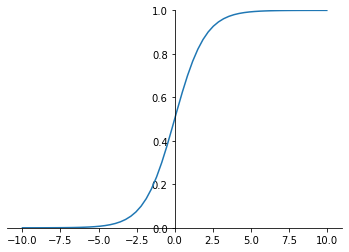

In [ ]:
# sigmoid
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('data', 0))
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
plt.ylim((0, 1))
sigmod=torch.sigmoid(x)
plt.plot(x.numpy(),sigmod.numpy())

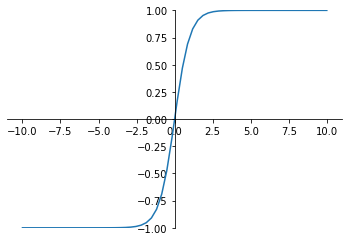

In [ ]:
# tanh
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('data', 0))
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
plt.ylim((-1, 1))
tanh=torch.tanh(x)
plt.plot(x.numpy(),tanh.numpy())

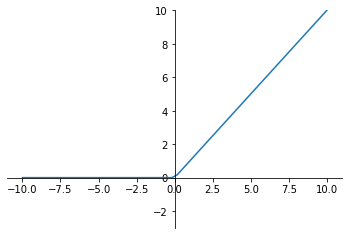

In [ ]:
# ReLu
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('data', 0))
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
plt.ylim((-3, 10))
relu=F.relu(x)
plt.plot(x.numpy(),relu.numpy())

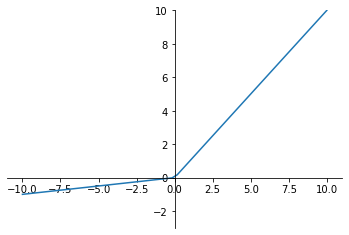

In [ ]:
# Leaky ReLu
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('data', 0))
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
plt.ylim((-3, 10))
l_relu=F.leaky_relu(x,0.1) # 这里的0.1是为了方便展示，理论上应为0.01甚至更小的值
plt.plot(x.numpy(),l_relu.numpy())

In [ ]:
net = nn.Sequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))

In [ ]:
X = torch.rand(2, 20)
net(X)

tensor([[-0.2490, -0.0767,  0.0392,  0.0549,  0.1722,  0.0958, -0.1524, -0.0722,
         -0.1284, -0.0656],
        [-0.1140, -0.0425, -0.0254,  0.0453,  0.1236,  0.1839, -0.1948, -0.0336,
         -0.1301, -0.0295]], grad_fn=<AddmmBackward0>)

In [ ]:
class MLP(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.hidden = nn.Linear(20, 256)
        self.out = nn.Linear(256, 10)
    def forward(self, x):
        return self.out(F.relu(self.hidden(x)))

In [ ]:
net = MLP()
net(X)

tensor([[-0.1873,  0.1422, -0.3196, -0.0566, -0.0136, -0.1181, -0.1549, -0.0795,
         -0.0173,  0.0190],
        [-0.1544,  0.0855, -0.2474, -0.1600,  0.0623, -0.0906, -0.1850, -0.0173,
          0.1027,  0.1023]], grad_fn=<AddmmBackward0>)

In [ ]:
class MySequential(nn.Module):
    def __init__(self, *args) -> None:
        super().__init__()
        for block in args:
            self._modules[block] = block
    def forward(self, X):
        for block in self._modules.values():
            X = block(X)
        return X
net = MySequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))
net(X)

tensor([[-0.2037, -0.1851,  0.0807,  0.1098, -0.0814, -0.0914, -0.0452, -0.0601,
         -0.0737,  0.1385],
        [-0.1965, -0.1479,  0.1353,  0.1391, -0.0761, -0.1883, -0.0011, -0.0177,
         -0.0331,  0.1397]], grad_fn=<AddmmBackward0>)

In [ ]:
class FixedHiddenMLP(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.rand_weight = torch.rand((20, 20), requires_grad=False)
        self.linear = nn.Linear(20, 20)
    def forward(self, X):
        X = self.linear(X)
        X = F.relu(torch.mm(X, self.rand_weight) + 1)
        X = self.linear(X)
        while X.abs().sum() > 1:
            X /= 2
        return X.sum()

net = FixedHiddenMLP()
net(X)

tensor(-0.2991, grad_fn=<SumBackward0>)

In [ ]:
# link module
class NestMLP(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.net = nn.Sequential(nn.Linear(20, 64), nn.ReLU(), nn.Linear(64, 32), nn.ReLU())
        self.linear = nn.Linear(32, 16)
    def forward(self, X):
        return self.linear(self.net(X))
chimera = nn.Sequential(NestMLP(), nn.Linear(16, 20), FixedHiddenMLP())
chimera(X)

tensor(-0.2181, grad_fn=<SumBackward0>)

In [ ]:
import torch, torch.nn
net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 1))
X = torch.rand(size=(2, 4))
net(X)

tensor([[-0.3345],
        [-0.2635]], grad_fn=<AddmmBackward0>)

In [ ]:
print(net[2].state_dict())

OrderedDict([('weight', tensor([[-0.2232,  0.2274, -0.3219, -0.0387,  0.0993, -0.2786,  0.1729,  0.0468]])), ('bias', tensor([-0.2006]))])


In [ ]:
type(net[2].bias), net[2].bias, net[2].bias.data

(torch.nn.parameter.Parameter,
 Parameter containing:
 tensor([-0.2006], requires_grad=True),
 tensor([-0.2006]))

In [ ]:
net[2].weight.grad == None

True

In [ ]:
torch.cuda.device_count()

1

In [ ]:
# covlutional
